<a href="https://colab.research.google.com/github/EgorSolovei/Decision-trees-in-nuclear-physics/blob/main/%D0%9E%D0%B1%D0%B7%D0%BE%D1%80_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

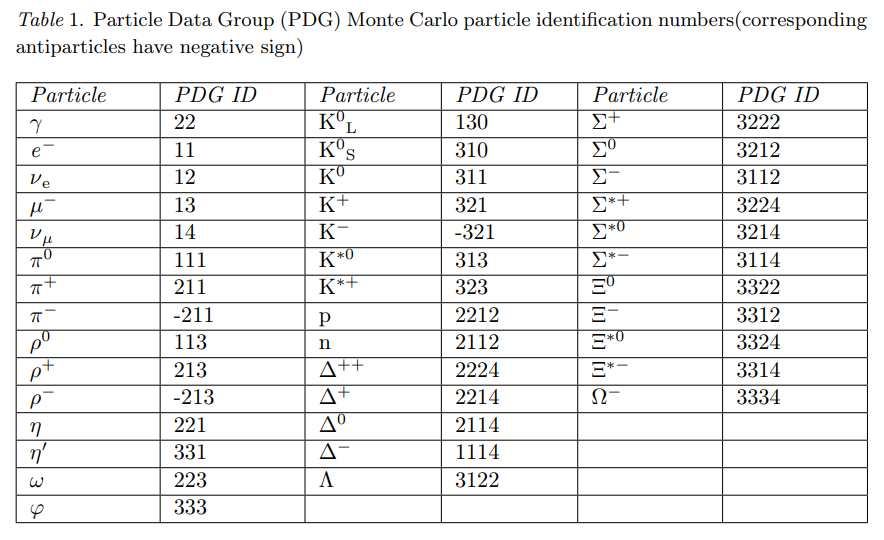

##Поставновка задачи
- Задача классификации. Мы хотим относить прицельный параметр к одному из классов, где классы - это какой-то отрезок. Получается для каждого столкновения мы имеем набор данных, который относится только к одному классу. Можно каждый раз перед началом данных каждого столкновения смотреть прицельный параметр, сразу относить его к назначенному классу и создать колонку, в которой и будет содержаться класс прицельного параметра. Именно эта колонка и будет нашим target'ом. Разбиения возьму точно такие же, как взял Кирилл, хотя ,по честному, нужно посмотреть распределение прицельных параметров, чтобы было равенство классов, которое (вроде бы) важно для алгоритмов: \\
(0; 7.0) - 1 класс, (7,0; 9,8) - 2 класс, (9,8; 12,0) - 3 класс, (12,0; 16,347) - 4 класс \\
Данные нужно готовить так, как будто они пришли на датчик. А датчик реагирует только на заряженные частицы и область, в которую прилетела частица



- Задача регрессии. По не пока ничего не могу рассудить

In [ ]:
import pandas as pd
import numpy as np

При загрузке файлов могут возникнуть проблемы. Нужно в первую строку каждого файла добавить название колонок, а потом переименовать их.

In [ ]:
data_1_df = pd.read_csv('Data_1.csv', sep=';', index_col=False)

data_1_df.head()

,particle_charge,lepton_number,strangeness,baryon_number,type_of_particles,impulse_x,impulse_y,impulse_z,impulse_z_lab,param_5,mass
0,1,1062,7.226,-6.821,2.384,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,0.000,0.000,22.000,0.038747,0.098051,0.239720,2.91390,-0.239720,0.0
2,0,1,0.000,0.000,22.000,0.290970,-0.050649,-0.132510,1.09150,0.132510,0.0
3,0,1,0.000,0.000,22.000,-0.110860,0.841320,0.211970,6.28620,-0.211970,0.0
4,0,1,0.000,0.000,22.000,0.096298,0.001396,-0.098164,0.21856,0.098164,0.0


In [ ]:
data_1_df.impulse_x[0]

nan

In [ ]:
data_1_df.isna().sum()

particle_charge         0
lepton_number           0
strangeness             0
baryon_number           0
type_of_particles       0
impulse_x            2000
impulse_y            2000
impulse_z            2000
impulse_z_lab        2000
param_5              2000
mass                 2000
dtype: int64

In [ ]:
data_1_df.shape

(1495919, 11)

In [ ]:
# убрали пока не нужные коллонки
data_1_df = data_1_df.drop(columns=['baryon_number', 'impulse_z_lab', 'param_5'])

# заменим все NaN, предполагая, что такого значения в массе нет, так как она должна быть положительна
data_1_df = data_1_df.fillna(-1)
data_1_df.head()

,particle_charge,lepton_number,strangeness,type_of_particles,impulse_x,impulse_y,impulse_z,mass
0,1,1062,7.226,2.384,-1.000000,-1.000000,-1.000000,-1.0
1,0,1,0.000,22.000,0.038747,0.098051,0.239720,0.0
2,0,1,0.000,22.000,0.290970,-0.050649,-0.132510,0.0
3,0,1,0.000,22.000,-0.110860,0.841320,0.211970,0.0
4,0,1,0.000,22.000,0.096298,0.001396,-0.098164,0.0


In [ ]:
# проверка сколько у нас событий (то есть мест, где раньше стояли NaN)
data_1_df.query('mass == -1').agg({'mass': 'count'}) 

mass    2000
dtype: int64

(0; 7.0) - 1 класс, (7,0; 9,8) - 2 класс, (9,8; 12,0) - 3 класс, (12,0; 16,347) - 4 класс \\
$[a_i, b_i)$ - отрезок $i$ - ого класса. Где левая граница включена, а правая - нет.
Мы знаем количество частиц в событии (столкновении), но мы какую-то часть отфильтровываем (по зарядям и импульсам). Поэтому мы вначале для всех частиц сделаем классификацию по прицельному параметру, а потом отфильтруем ненужные. \\
Можно вначале сделать фильтрацию данных, а потом классификацию, но для этого нужно придумывать другой, более сложный алгоритм

In [ ]:
a_1 = 0
b_1 = 7
a_2 = 7
b_2 = 9.8
a_3 = 9.8
b_3 = 12
a_4 = 12
b_4 = 16.347

# созданим заранее колонку с классом прицельного параметра, заполненную нулями
data_1_df['class_of_impact_param'] = 0

# работает долго. Наверняка можно написать лучше
# классифицирует прицельный параметр
def class_impact_param(data):
    for i in range(data.shape[0]):
        if data.mass[i] == -1:
            impact_param = data.strangeness[i]
            quantity_of_particles = int(data.lepton_number[i]) # количество элементов в событии
            # если нижнюю границу делать i + 1 + quantity_of_particles, то 0 меньше, чем 2000, 
            # если нижнюю границу делать i + quantity_of_particles, то 0 больше, чем 2000
            if a_1 <= impact_param < b_1:
                data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 1
            if a_2 <= impact_param < b_2:
                data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 2
            if a_3 <= impact_param < b_3:
                data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 3
            if a_4 <= impact_param <= b_4: # b_4 - граница включительна, так как она последняя
                data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 4

            # # для задачи регрессии
            # data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = impact_param
        

In [ ]:
class_impact_param(data_1_df)
!

<ipython-input-135-cb8f80b64338>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 2
<ipython-input-135-cb8f80b64338>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.class_of_impact_param[i + 1: i + 1 + quantity_of_particles] = 4
<ipython-input-135-cb8f80b64338>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.class_of_impact_param[i + 1: i + 1 + quantity_o

In [ ]:
data_1_df.head()

,particle_charge,lepton_number,strangeness,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param
0,1,1062,7.226,2.384,-1.000000,-1.000000,-1.000000,-1.0,0
1,0,1,0.000,22.000,0.038747,0.098051,0.239720,0.0,2
2,0,1,0.000,22.000,0.290970,-0.050649,-0.132510,0.0,2
3,0,1,0.000,22.000,-0.110860,0.841320,0.211970,0.0,2
4,0,1,0.000,22.000,0.096298,0.001396,-0.098164,0.0,2


In [ ]:
"""
должно быть 2000 нулей в столбце class_of_impact_param, потому что у нас всего 2000 событий
чему верить? в файле последний номер события 2000, а количество NaN в таблице 1411
с кодом всё впорядке, в csv файле изначально 1411 строка, так как Excel не может открыть больше строк.
Если открывать с через блокнот, то всё будет впорядке
"""

# видно что есть диcбаланс классов
data_1_df.groupby(['class_of_impact_param']).agg({'class_of_impact_param': 'count'}, as_index=False)

,class_of_impact_param
class_of_impact_param,
0,2000
1,834239
2,449708
3,170803
4,39169


In [ ]:
data_1_df.query('mass == -1').agg({'mass': 'count'}) # сходится с изначальным показанием

mass    2000
dtype: int64

In [ ]:
# больше нам эти колонки не нужны, так как мы уже сделали классификацию по прицельному параметру
data_1_df = data_1_df.drop(columns=['lepton_number', 'strangeness'])
data_1_df = data_1_df.query('class_of_impact_param != 0')

In [ ]:
data_1_df.head()

,particle_charge,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param
1,0,22.0,0.038747,0.098051,0.239720,0.0,2
2,0,22.0,0.290970,-0.050649,-0.132510,0.0,2
3,0,22.0,-0.110860,0.841320,0.211970,0.0,2
4,0,22.0,0.096298,0.001396,-0.098164,0.0,2
5,0,22.0,0.041370,0.257660,-0.085403,0.0,2


## Фильтрация
1) только заряженные частицы != 0 \\
2) посчитаем длину вектора импульса \\
3) На первом этапе можно не учитывать тип частицы. \\
4) Данные после столкновения \\
5) Попадает ли частица на детектор - первый этап - очистить данные по различным параметрам \\
6) Мы хотим предсказывать прицельный параметр - второй этап - задача регрессии

In [ ]:
data_1_df = data_1_df.query("particle_charge != 0") # убрали все нулевые заряды

|$\vec{P}| = \sqrt{p_{x}^2 + p_{y}^2+  p_{z}^2}$

In [ ]:
# посчитали суммарный импульс для каждой частицы
def total_impulse(df): 
    total = np.power(df.impulse_x, 2) + np.power(df.impulse_y, 2) + np.power(df.impulse_z, 2)
    return np.sqrt(total)


data_1_df['modul_sum_impulse'] = total_impulse(data_1_df)

<ipython-input-143-d603c81c05b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1_df['modul_sum_impulse'] = total_impulse(data_1_df)


переименовать impulse_z в momentum_z


Далее введём параметры нашего эксперимента: \\
- Внешний радиус кольца детектора - R
- радиус выреза для 1-ого, 2-ого и 3-его кольца соответственно - $r_{cut_1}$, $r_{cut_2}$, $r_{cut_3}$ (для начала будем считать, что он равен 0) \\
- расстояние до 1-ого, 2-ого и 3-его кольца соответственно - $dist_1$, $dist_2$, $dist_3$. \\

Сделаем фильтр, который будет проверять долетит ли частица до датчиков. \\

Для каждого кольца мы имеем различные условия прилёта для каждой частицы. Усложнить алгоритм отобора можно так: если частица прилетела уже на какой-либо датчик, то не смысла проверять её прилет на другие датчики. \\



Введём сферические координаты: \\
$p_z = |\vec P| cos(ϴ) cos(γ)$ \\
$p_x = |\vec P| cos(ϴ) sin(γ)$ \\
$p_y = |\vec P| sin(ϴ)$ \\

Тогда: \\
$\gamma = arctg(\frac{p_x}{p_z})$ \\
$ϴ = arcsin(\frac{p_y}{|\vec P|})$ 

(Нужно подумать насчёт ориентации векторов)

In [ ]:
data_1_df.head()

,particle_charge,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse
19,1,211.0,0.228800,-0.220680,-0.856760,0.13957,2,0.913831
21,1,211.0,-0.055182,0.188130,-0.458750,0.13957,2,0.498888
25,1,211.0,0.096027,0.055379,0.066079,0.13957,2,0.129052
34,1,211.0,-0.057866,0.056417,-0.195960,0.13957,2,0.211971
36,1,2212.0,-0.418190,-0.067341,9.104700,0.93828,2,9.114548



Условия для отбора частиц: \\
$ \alpha_n < \gamma_i < \beta_n $ и $ \alpha_n < \theta < \beta_n$ \\
где: \\
$ \alpha_n = arctg({\frac{r_{cut_n}}{dist_n}}) $ для n = 1, 2, 3 \\
$ \beta_n = arctg({\frac{R}{dist_1}}) $ \\

А для  $\beta_2$, $\beta_3$: $\beta_2 = \alpha_1 $ и $\beta_3 = \alpha_2$


In [ ]:
# случай, когда у нас 3 датчика в положительном направлении

R = 2
r_cut = 0.3
dist = [1, 2, 3]

#граничные углы
boundary_angles_alpha = [np.arctan(r_cut / dist_i) for dist_i in dist]
boundary_angles_betta = [np.arctan(R / dist[0]), boundary_angles_alpha[0], boundary_angles_alpha[1]]

# проверка, что частица долетит до датчика. Границы углов не включительно
def to_sensor(df, alpha, betta):
    return ((np.arctan(df.impulse_x / df.impulse_z).between(alpha, betta, inclusive="neither")) & \
                (np.arcsin(df.impulse_y / df.modul_sum_impulse).between(alpha, betta, inclusive="neither")))\
                .astype(int)

# похоже на колхоз
data_1_df['sensor_number_1'] = to_sensor(data_1_df, alpha=boundary_angles_alpha[0], betta=boundary_angles_betta[0])
data_1_df['sensor_number_2'] = to_sensor(data_1_df, alpha=boundary_angles_alpha[1], betta=boundary_angles_betta[1])
data_1_df['sensor_number_3'] = to_sensor(data_1_df, alpha=boundary_angles_alpha[2], betta=boundary_angles_betta[2])

data_1_df.head()

,particle_charge,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse,sensor_number_1,sensor_number_2,sensor_number_3
19,1,211.0,0.228800,-0.220680,-0.856760,0.13957,2,0.913831,0,0,0
21,1,211.0,-0.055182,0.188130,-0.458750,0.13957,2,0.498888,0,0,0
25,1,211.0,0.096027,0.055379,0.066079,0.13957,2,0.129052,1,0,0
34,1,211.0,-0.057866,0.056417,-0.195960,0.13957,2,0.211971,0,1,0
36,1,2212.0,-0.418190,-0.067341,9.104700,0.93828,2,9.114548,0,0,0


In [ ]:
# разделим на два разных датасета для отрицательного и положительного направления 
# и оставим только те частицы, которые долетели до датчиков

data_1_df_positive = data_1_df.query("impulse_z > 0 & \
                            (sensor_number_1 == 1 | sensor_number_2 == 1 | sensor_number_3 == 1)") 
data_1_df_negativ = data_1_df.query("impulse_z < 0 & \
                            (sensor_number_1 == 1 | sensor_number_2 == 1 | sensor_number_3 == 1)")

data_1_df_positive.head()

,particle_charge,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse,sensor_number_1,sensor_number_2,sensor_number_3
25,1,211.0,0.096027,0.055379,0.066079,0.13957,2,0.129052,1,0,0
185,1,2212.0,0.404760,0.375710,2.187800,0.93828,2,2.256426,0,1,0
198,1,211.0,0.209220,0.226530,0.950070,0.13957,2,0.998860,0,1,0
353,-1,-211.0,0.194800,0.121040,0.299170,0.13957,2,0.376962,1,0,0
464,-1,-211.0,0.149460,0.436080,0.300050,0.13957,2,0.550031,1,0,0


Я представлял, что этот датафрейм будет пустой, так как датчик стоит только в положительном направлении. \\
Судя по всему, если я делаю отбор только по углам, то это работает и для отрицательного направления. Тогда в случае большего количества датчиков, можно вводить только положительные части, а потом сделать фильтрацию по направлению impulse_z.

In [ ]:
data_1_df_negativ.head()

,particle_charge,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse,sensor_number_1,sensor_number_2,sensor_number_3
34,1,211.0,-0.057866,0.056417,-0.195960,0.13957,2,0.211971,0,1,0
123,1,2212.0,-0.205860,0.197810,-1.844900,0.93828,2,1.866859,0,0,1
350,-1,-211.0,-0.012051,0.040642,-0.022755,0.13957,2,0.048112,1,0,0
529,1,211.0,-0.215960,0.415280,-0.706030,0.13957,2,0.847098,1,0,0
561,1,211.0,-0.150810,0.300520,-0.462250,0.13957,2,0.571604,1,0,0


In [ ]:
data_1_df_positive.shape, data_1_df_negativ.shape, data_1_df.shape

((23529, 11), (24023, 11), (808625, 11))

In [ ]:
boundary_angles_alpha

[0.2914567944778671, 0.14888994760949725, 0.09966865249116202]

In [ ]:
boundary_angles_betta

[1.1071487177940904, 0.2914567944778671, 0.14888994760949725]

Если делать такое разбиение, то получится 24 сектора
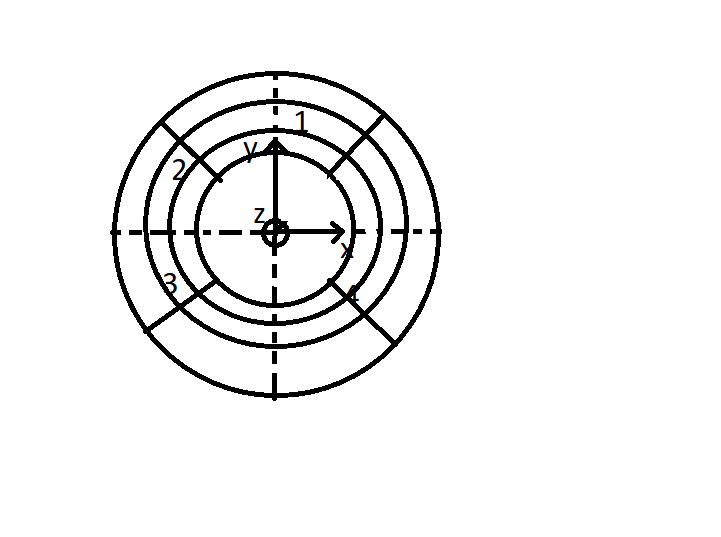

нужно будет вводить радиусы колец (2 дополнительных), если сделать как на фото

In [ ]:
data_1_df.head()

,particle_charge,type_of_particles,impulse_x,impulse_y,impulse_z,mass,class_of_impact_param,modul_sum_impulse,sensor_number_1,sensor_number_2,sensor_number_3
19,1,211.0,0.228800,-0.220680,-0.856760,0.13957,2,0.913831,0,0,0
21,1,211.0,-0.055182,0.188130,-0.458750,0.13957,2,0.498888,0,0,0
25,1,211.0,0.096027,0.055379,0.066079,0.13957,2,0.129052,1,0,0
34,1,211.0,-0.057866,0.056417,-0.195960,0.13957,2,0.211971,0,1,0
36,1,2212.0,-0.418190,-0.067341,9.104700,0.93828,2,9.114548,0,0,0


In [ ]:
# создадим отдельно для каждого датчика датафрейм (содержат как положительное, так и отрицательное направление)
data_1_sensor = data_1_df.query("sensor_number_1==1")
data_2_sensor = data_1_df.query("sensor_number_2==1")
data_3_sensor = data_1_df.query("sensor_number_3==1")

In [ ]:
# вообще так (по знаку импульса) разделять не очень хорошая идея, так как можно разделить только на 4 части.
# лучше реализовывать это через углы.

# не понимаю, почему не работает? 
def get_number_feild(x_momentum, y_momentum):
    if (x_momentum > 0) & (y_momentum > 0):
        return 1
    elif (x_momentum > 0) & (y_momentum < 0):
        return 4
    elif (x_momentum < 0) & (y_momentum > 0):
        return 2
    else:
        return 3
    
data_1_sensor['field'] = get_number_feild(data_1_sensor.impulse_x, data_1_sensor.impulse_y)
data_1_sensor.head()

ValueError: ignored

Вообще, это можно считать готовыми данными для загрузки в модель. Думаю, колонку achieve можно удалить, так как она не несёт никакой информации для модели. \\
Для упрощения модели, можно попробовать удалить колонки impulse_x, impulse_y, impulse_z и посмотреть насколько сильно измениться качество предсказания. \\
Target колонка - class_of_impact_param. \\
Стоит ли тут сделать one hot encoding? Влияет ли это на модель?